In [38]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def fix_csv(metadata):
    """
    Fix the paths in the metadata CSV by replacing incorrect parts of the path
    
    Removes NaN rows in the metadata CSV.
    """
    metadata.dropna(inplace=True) # remove missing values

    # Replace the incorrect directory name with the correct one
    metadata['path_to_image'] = metadata['path_to_image'].apply(
        lambda x: x.replace('BreaKHis_v1/', 'BreaKHis_v1 2/')
    )
    
    return metadata

In [40]:
# DEFINE DIRECTORY PATH FOR DATASET (\DeepLearning24_25\)
# ---------------------------------
source_directory = r"D:\DeepLearning24_25"
# ---------------------------------
path_img_metadata = os.path.join(source_directory, 'BreaKHis_v1 2/histology_slides/breast/image_data.csv')
img_metadata_df = pd.read_csv(path_img_metadata)

In [41]:
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    3
Cancer Type            4
Magnification          4
dtype: int64

In [81]:
img_metadata_df = fix_csv(img_metadata_df)
img_metadata_df.head(3)

,path_to_image,Benign or Malignant,Cancer Type,Magnification
0,BreaKHis_v1 2/histology_slides/breast/benign/S...,Benign,Adenosis,100X
1,BreaKHis_v1 2/histology_slides/breast/benign/S...,Benign,Adenosis,100X
2,BreaKHis_v1 2/histology_slides/breast/benign/S...,Benign,Adenosis,100X


In [82]:
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    0
Cancer Type            0
Magnification          0
dtype: int64

In [103]:
def update_image_paths(metadata):
    metadata['image_name'] = metadata['path_to_image'].apply(lambda x: x.split('/')[-1])
    metadata['image_location'] = metadata.apply(
        lambda row: 'Train' if os.path.exists(os.path.join('data', row['Magnification'], 'train', row['image_name']))
        else 'Test' if os.path.exists(os.path.join('data', row['Magnification'], 'test', row['image_name']))
        else 'Val' if os.path.exists(os.path.join('data', row['Magnification'], 'val', row['image_name']))
        else 'Not_Found',
        axis=1
    )
    metadata['path_to_image'] = metadata.apply(
        lambda row: os.path.join('data', row['Magnification'], row['image_location'], row['image_name']),
        axis=1
    )
    metadata.drop(columns=['image_name', 'image_location'], inplace=True)
    return metadata

img_metadata_df = update_image_paths(img_metadata_df)
img_metadata_df.head(3)

,path_to_image,Benign or Malignant,Cancer Type,Magnification
0,data\100X\Train\SOB_B_A-14-22549AB-100-011.png,Benign,Adenosis,100X
1,data\100X\Test\SOB_B_A-14-22549AB-100-005.png,Benign,Adenosis,100X
2,data\100X\Test\SOB_B_A-14-22549AB-100-004.png,Benign,Adenosis,100X


In [84]:
grouped = img_metadata_df.groupby(
    ['Benign or Malignant', 'Cancer Type', 'Magnification']
).size().reset_index(name='Count')

# Align magnification levels as columns under each subclass
pivot_table = grouped.pivot_table(
    index=['Benign or Malignant', 'Cancer Type'],
    columns='Magnification',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

# Reorder magnification columns as in the image
magnification_order = ['40X', '100X', '200X', '400X']
pivot_table = pivot_table.reindex(columns=magnification_order, fill_value=0)

pivot_table['Total'] = pivot_table.sum(axis=1)

column_totals = pivot_table.sum(axis=0)
pivot_table.loc[('Total', ''), :] = column_totals

pivot_table = pivot_table.astype(int)
pivot_table

Magnification                             40X  100X  200X  400X  Total
Benign or Malignant Cancer Type                                       
Benign              Adenosis              114   113   111   106    444
                    Fibroadenoma          253   260   264   237   1014
                    Phyllodes Tumor       109   121   108   115    453
                    Tubular Adenoma       149   150   140   130    569
Malignant           Ductal Carcinoma      863   903   896   788   3450
                    Lobular Carcinoma     156   170   163   137    626
                    Mucinous Carcinoma    205   221   195   168    789
                    Papillary Carcinoma   145   142   135   138    560
Total                                    1994  2080  2012  1819   7905

In [91]:
grouped = img_metadata_df.groupby(['Magnification', 'Benign or Malignant']).size().unstack(fill_value=0)

grouped['Total'] = grouped.sum(axis=1)

column_totals = grouped.sum(axis=0)
grouped.loc['Total'] = column_totals

grouped.reset_index().rename(columns={'index': 'Magnification'})

grouped

Benign or Malignant,Benign,Malignant,Total
Magnification,,,
100X,644,1436,2080
200X,623,1389,2012
400X,588,1231,1819
40X,625,1369,1994
Total,2480,5425,7905


**IMPORTANT:** run `setup_data.py`

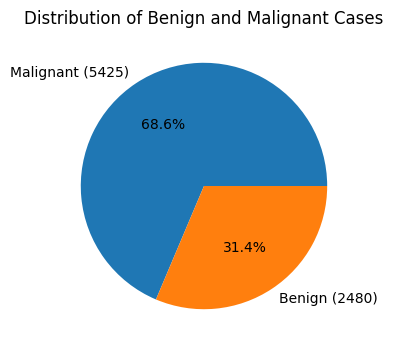

In [87]:
class_counts = img_metadata_df['Benign or Malignant'].value_counts()
class_counts.plot(kind='pie', figsize=(8, 4), autopct='%1.1f%%', labels=[f'{label} ({count})' for label, count in zip(class_counts.index, class_counts)])
plt.ylabel('')
plt.title('Distribution of Benign and Malignant Cases')
plt.show()

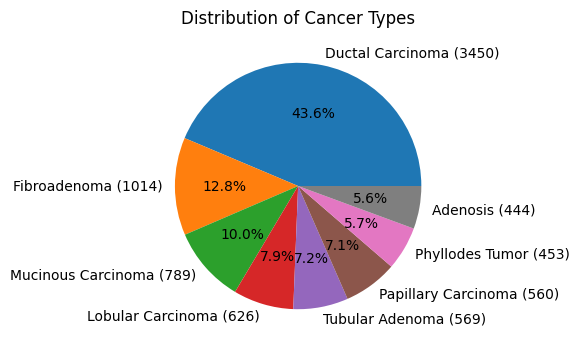

In [88]:
cancer_type_counts = img_metadata_df['Cancer Type'].value_counts()
cancer_type_counts.plot(kind='pie', figsize=(8, 4), autopct='%1.1f%%', labels=[f'{label} ({count})' for label, count in zip(cancer_type_counts.index, cancer_type_counts)])
plt.ylabel('')
plt.title('Distribution of Cancer Types')
plt.show()

In [105]:
def check_image_resolutions(metadata):
    resolutions = []
    for idx, row in metadata.iterrows():
        try:
            with Image.open(row['path_to_image']) as img:
                resolutions.append(img.size)
        except Exception as e:
            print(f"Error loading image {row['path_to_image']}: {e}")
    return resolutions

resolutions = check_image_resolutions(img_metadata_df)
resolutions_df = pd.DataFrame(resolutions, columns=['width', 'height'])
print("\nImage Resolutions:\n", resolutions_df.describe())


Image Resolutions:
         width       height
count  7905.0  7905.000000
mean    700.0   459.962555
std       0.0     0.385221
min     700.0   456.000000
25%     700.0   460.000000
50%     700.0   460.000000
75%     700.0   460.000000
max     700.0   460.000000
